In [1]:
import numpy as np
import os,re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

In [2]:
class MLP_ODE(keras.Model):
    """Multi-layer NN ode_fn."""
    def __init__(self, num_hidden, num_layers, num_output,num_cond=2,name='mlp_ode'):
        super(MLP_ODE, self).__init__()
        self._num_hidden = num_hidden
        self._num_output = num_output
        self._num_layers = num_layers
        self._num_cond = num_cond
        self._modules = []
        
        #Fully connected layers with tanh activation and linear output
        self._modules.append(Input(shape=(1+self._num_output+self._num_cond))) #time is part of the inputs
        for _ in range(self._num_layers - 1):
            self._modules.append(layers.Dense(self._num_hidden,activation='tanh'))
            
        self._modules.append(layers.Dense(self._num_output,activation=None))
        self._model = keras.Sequential(self._modules)

        if self._num_cond > 1:
            #In more dimensiona, is useful to feed the conditional distributions after passing through an independent network model
            self._cond_model = keras.Sequential(
                [
                    Input(shape=(self._num_cond)),
                    layers.Dense(self._num_hidden,activation='relu'),
                    layers.Dense(self._num_cond,activation=None),
                ])
        
    @tf.function
    def call(self, t, data,conditional_input=None):
        if self._num_cond==1:
            #No network for a single feature
            cond_transform=tf.cast(conditional_input,dtype=tf.float32)
        else:
            cond_transform = self._cond_model(conditional_input)
            
        t = t*tf.ones([data.shape[0],1])
        inputs = tf.concat([t, data,cond_transform], -1)
        return self._model(inputs)

def make_bijector_kwargs(bijector, name_to_kwargs):
    #Hack to pass the conditional information through all the bijector layers
    if hasattr(bijector, 'bijectors'):
        return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
    else:
        for name_regex, kwargs in name_to_kwargs.items():
            if re.match(name_regex, bijector.name):
                return kwargs
    return {}

def save_model(model,name="ffjord",checkpoint_dir = '../checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    model.save_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf'))

def load_model(model,name="ffjord",checkpoint_dir = '../checkpoints'):
    model.load_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf')).expect_partial()
    
        
class FFJORD(keras.Model):
    def __init__(self, stacked_mlps, batch_size,num_output,trace_type='hutchinson',name='FFJORD'):
        super(FFJORD, self).__init__()
        self._num_output=num_output
        self._batch_size = batch_size 
        ode_solve_fn = tfp.math.ode.DormandPrince(atol=1e-5).solve
        #Gaussian noise to trace solver
        if trace_type=='hutchinson':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
        elif trace_type == 'exact':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
        else:
            raise Exception("Invalid trace estimator")
        
        
        bijectors = []
        for imlp,mlp in enumerate(stacked_mlps):
            ffjord = tfb.FFJORD(
                state_time_derivative_fn=mlp,
                ode_solve_fn=ode_solve_fn,
                trace_augmentation_fn=trace_augmentation_fn,
                name='bijector{}'.format(imlp) #Bijectors need to be names to receive conditional inputs
            )
            bijectors.append(ffjord)

        #Reverse the bijector order
        self.chain = tfb.Chain(list(reversed(bijectors)))

        self.loss_tracker = keras.metrics.Mean(name="loss")
        #Determien the base distribution
        self.base_distribution = tfp.distributions.MultivariateNormalDiag(
            loc=self._num_output*[0.0], scale_diag=self._num_output*[1.0]
        )
        
        self.flow=self.Transform()
        self._variables = self.flow.variables
        
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]
    
    @tf.function
    def call(self, inputs, conditional_input=None):
        kwargs = make_bijector_kwargs(self.flow.bijector,{'bijector.': {'conditional_input':conditional_input }})
        return self.flow.bijector.forward(inputs,**kwargs)
        
            
    def Transform(self):        
        return tfd.TransformedDistribution(distribution=self.base_distribution, bijector=self.chain)

    
    @tf.function
    def log_loss(self,_x,_c):
        loss = -tf.reduce_mean(self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        ))
        
        return loss
    
    @tf.function
    def conditional_prob(self,_x,_c):
        prob = self.flow.prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
        
        return prob
    
    @tf.function
    def conditional_log_prob(self,_x,_c):
        return self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
    
    
    @tf.function()
    def train_step(self, values):
        #Full shape needs to be given when using tf.dataset
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))

        with tf.GradientTape() as tape:
            loss = self.log_loss(data,cond)
            
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
    
    @tf.function
    def test_step(self, values):
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))
        
        loss = self.log_loss(data,cond)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [3]:
# Target dataset: 2D Gaussians centered at (c,c)
DATASET_SIZE = 1600*256
BATCH_SIZE = 256

def generate_2D_gaussian(n):
    cond_vals = np.random.uniform(-0.5, 1.5, (n,1))
    samples = np.empty([n,2]).astype(np.float32)
    for i in range(n):
        samples[i] = np.random.normal(cond_vals[i], 1, (1,2))
    return np.concatenate([samples, cond_vals],-1) #Last dimensions are the conditional values

samples_train = generate_2D_gaussian(DATASET_SIZE)
#samples_val = generate_2D_gaussian(VAL_SIZE)

print(f"Training samples: {samples_train}")
#print(f"Validation samples: {samples_val}")

Training samples: [[ 0.95839149  1.73929715  1.47218138]
 [-0.05280919  0.66860509  0.19039239]
 [-0.50933653 -0.87665445 -0.20202411]
 ...
 [ 2.82496262  0.14363588  0.94301895]
 [-0.73001605  0.11761271 -0.00948353]
 [-0.08301755  3.13085318  1.14651757]]


## Some infrastructure for hyperparameter search

In [21]:
def hpo(LR, STACKED_FFJORDS, NUM_LAYERS):
    NUM_OUTPUT = 2 #Output dimension
    NUM_HIDDEN = 4*NUM_OUTPUT #Hidden layer node size
    NUM_COND = 1 #Number of conditional dimensions
    
    #Stack of bijectors 
    stacked_mlps = []
    for _ in range(STACKED_FFJORDS):
        mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT,NUM_COND)
        stacked_mlps.append(mlp_model)

    #Create the model
    model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='hutchinson')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))
    
    callbacks=[
        EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)
    ]
    
    history = model.fit(
        samples_train,
        batch_size=BATCH_SIZE,
        epochs=40,
        verbose=1,
        validation_split=0.1,
        callbacks=callbacks,
    )
    
    num_epochs = callbacks[0].stopped_epoch
    
    return num_epochs

In [ ]:
from itertools import product

LRs = [1e-1, 1e-2, 1e-3, 1e-4]
STACKED_FFJORDSs = [1, 2, 3, 4]
NUM_LAYERSs = [1, 2, 4]

hpo_results = {}

start_time_total = time.time()

for LR, STACKED_FFJORDS, NUM_LAYERS in product(LRs, STACKED_FFJORDSs, NUM_LAYERSs):
    print(f"LR: {LR}, STACKED_FFJORDS: {STACKED_FFJORDS}, NUM_LAYERS: {NUM_LAYERS}")
    start_time = time.time()
    test_loss, num_epochs = hpo(LR, STACKED_FFJORDS, NUM_LAYERS)
    
    print(f"Test loss: {test_loss}")
    print(f"Training + evaluation took: {time.time() - start_time} seconds")
    
    hpo_results[(LR, STACKED_FFJORDS, NUM_LAYERS, num_epochs)] = test_loss

print(f"HP search total time: {time.time() - start_time_total} seconds")

In [151]:
best_hp = min(hpo_results, key=hpo_results.get)
print(best_hp)

(0.01, 2, 1, 23)


## Train model

In [9]:
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

In [4]:
LR = 5e-4
NUM_EPOCHS = 40
STACKED_FFJORDS = 5 #Number of stacked transformations
NUM_LAYERS = 3 #Hiddden layers per bijector
NUM_OUTPUT = 2 #Output dimension
NUM_HIDDEN = 12*NUM_OUTPUT #Hidden layer node size
NUM_COND = 1 #Number of conditional dimensions


#Stack of bijectors 
stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT,NUM_COND)
    stacked_mlps.append(mlp_model)

#Create the model
model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='hutchinson')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))

callbacks=[
        EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)
    ]

trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams
print(f"Number of trainable params: {trainableParams}")
print(f"Number of nontrainable params: {nonTrainableParams}")
print(f"Number of total params: {totalParams}")

history = model.fit(
    samples_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_split=0.1,
    #validation_data=samples_val,
    callbacks=callbacks,
)
    
num_epochs = callbacks[0].stopped_epoch

2022-06-01 19:47:16.781580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/global/home/users/haoxing_du/anaconda3/envs/new_env/lib/:/global/home/users/haoxing_du/anaconda3/envs/tf2/lib/
2022-06-01 19:47:16.781608: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-01 19:47:16.782238: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To 

Number of trainable params: 3850
Number of nontrainable params: 2.0
Number of total params: 3852.0
Epoch 1/40
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
1440/1440 [==============================] - 283s 156ms/step - loss: 2.8536 - val_loss: 2.8507 - lr: 5.0000e-04
Epoch 2/40
1440/1440 [==============================] - 221s 153ms/step - loss: 2.8357 - val_loss: 2.8417 - lr: 5.0000e-04
Epoch 3/40
1440/1440 [==============================] - 223s 155ms/step - loss: 2.8411 - val_loss: 2.8456 - lr: 5.0000e-04
Epoch 4/40
1440/1440 [==============================] - ETA: 0s - loss: 2.8377
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1440/1440 [==============================] - 232s 161ms/step - loss: 2.8377 - val_loss: 2.8576 - lr: 5.0000e-04
Epoch 5/40
1440

In [277]:
history.history

{'loss': [2.856133460998535,
  2.841465950012207,
  2.840606451034546,
  2.8390564918518066,
  2.8414807319641113,
  2.841613531112671,
  2.840528964996338],
 'val_loss': [2.8413872718811035,
  2.829249858856201,
  2.837268114089966,
  2.839080572128296,
  2.839385747909546,
  2.8472650051116943,
  2.8407976627349854],
 'lr': [0.0005, 0.0005, 0.0005, 0.0005, 0.00025, 0.00025, 0.000125]}

In [5]:
NSAMPLES = DATASET_SIZE

#Sample the learned distribution
transformed = model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': samples_train[:,2].reshape(NSAMPLES,1)}})
)

transformed_first = model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': np.ones((NSAMPLES,1),dtype=np.float32)}})
)

transformed_second = model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': np.zeros((NSAMPLES,1),dtype=np.float32)}})
)

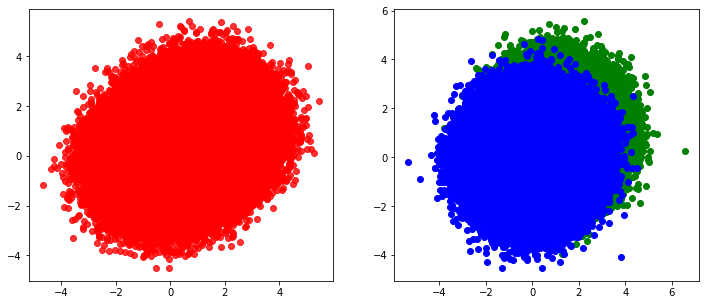

In [6]:
#Plotting    
fig = plt.figure(figsize=(12, 5))
plt.subplot(121)    
plt.scatter(transformed[:, 0], transformed[:, 1], color="r", alpha=0.8)
plt.subplot(122)
plt.scatter(transformed_first[:, 0], transformed_first[:, 1], color="g")
plt.scatter(transformed_second[:, 0], transformed_second[:, 1], color="b")

In [7]:
# Saving the model for future inference
save_model(model)

# Let's create a new model with the same architecture, but with the exact trace estimator
new_model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='exact',name='loaded_model')
load_model(new_model)

# Verify that no fluctuations are involded
point = [[0,1]]
cond = [[1]]
print(new_model.conditional_prob(point,cond))
print(new_model.conditional_prob(point,cond))
print(new_model.conditional_prob(point,cond))

tf.Tensor([0.09904531], shape=(1,), dtype=float32)
tf.Tensor([0.09904531], shape=(1,), dtype=float32)
tf.Tensor([0.09904531], shape=(1,), dtype=float32)


In [ ]:
# Alternative plotting: joint distribution, conditional value = 1
fig = plt.figure(figsize=(8, 9))
plt.subplot(311)    
plt.scatter(transformed[:, 0], transformed[:, 1], color="r")
plt.subplot(312)
plt.scatter(transformed_first[:, 0], transformed_first[:, 1], color="g")
plt.subplot(313)
plt.scatter(transformed_second[:, 0], transformed_second[:, 1], color="b")

# Maximum likelihood estimate 
Find the most probable conditional value z for a given data point x.

### Math derivation
Mathematically, what is the most likely $z$ for point $x=(a,b)$? We know the underlying distribution is a superposition of Gaussians centered at $(z,z)$. So for a point $(a,b)$, the most likely $z$ is such that $|(a,b) - (z,z)|$ is minimized.

$$y = -x+c \implies b = -a + c \implies c = a+b$$
$$y = -x+a+b = x \implies x = (a+b)/2$$

Therefore, the most likely $z$ is $(a+b)/2$ if  $0 \leq (a+b)/2 \leq 1$; $0$ if $a+b < 0$; and $1$ if $a+b > 2$.

e.g. for $(x,0.5)$, $z = (x+0.5)/2$.

In [8]:
def mle_math(x):
    a, b = x
    if (a+b)/2 < 0:
        return 0
    elif (a+b)/2 > 1:
        return 1
    else:
        return (a+b)/2

mle_math((0.5,1))

0.75

### The first method is grid search: simply scan over many values of z, and remember the one that gives the highest p(x|z).

In [9]:
import time

random_index = np.random.randint(DATASET_SIZE)
#random_index = 0
random_point = transformed[random_index]
#print(random_point)

N = 100

def scanner(point, N):
    start = time.time()
    points = np.array([point] * (N+1))
    zs = np.array([i/N for i in range(N+1)]).reshape((N+1,1))
    #print(points, zs)
    log_probs = new_model.conditional_log_prob(points, zs)

    max_prob = np.amax(log_probs)
    max_index = np.argmax(log_probs)

    c_max = max_index / N
    
    end = time.time()
    #print(f"Run time (s): {end-start}")
    return c_max

c_max = scanner(random_point, N)
c_max_math = mle_math(random_point)
print(f"Random point: {random_point}")
print(f"Most likely cond value (analytical): {c_max_math}")
print(f"Most likely cond value (scanning): {c_max}")

Random point: [ 1.8463279 -0.9467457]
Most likely cond value (analytical): 0.4497911036014557
Most likely cond value (scanning): 0.4


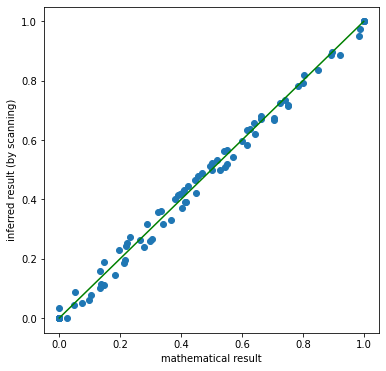

In [11]:
N = 500
n_points = 100

points = np.random.uniform(-0.5, 1.5, (n_points,2)).astype(np.float32)
#print(points)

c_maxs = []
c_max_maths = []

for point in points:
    c_max = scanner(point, N)
    c_max_math = mle_math(point)
    c_maxs.append(c_max)
    c_max_maths.append(c_max_math)
    #if c_max_math<0.1:
    #    print(point, c_max, c_max_math)

fig = plt.figure(figsize=(6,6))
plt.scatter(c_max_maths, c_maxs)
plt.xlabel("mathematical result")
plt.ylabel("inferred result (by scanning)")
plt.plot([0,0.5,1], [0,0.5,1], c='green')

In [187]:
random_point = np.random.uniform(-1, 2, (2,)).astype(np.float32)

c_max = scanner(random_point, N)
c_max_math = mle_math(random_point)
print(f"Random point: {random_point}")
print(f"Most likely cond value (analytical): {c_max_math}")
print(f"Most likely cond value (scanning): {c_max}")

Random point: [0.46125662 0.42954218]
Most likely cond value (analytical): 0.4453994035720825
Most likely cond value (scanning): 0.47


(**defunct**) It looks like there are quite a few points for which the most likely $z$ value should be nonzero, but gets reported as 0 by the scanner. To investigate, let's find one such point, and plot $p(x|z)$ for that point:

In [ ]:
fixed_x = [0.05526591, 0.10162263]
plot_pxz_fixed_x(fixed_x) # This function is defined below

In [ ]:
N = 20
coords = np.linspace(0, 1, N+1)
ys = np.ones(N+1)
points = np.stack((xs, xs), axis=-1).astype(np.float32)

c_maxs = np.empty([N+1,N+1])

xdata, ydata, zdata = [], [], []

for i,x in enumerate(coords):
    for j,y in enumerate(coords):
        point = tf.constant([x,y], dtype=np.float32)
        c_max = scanner(point, N)
        c_maxs[i][j] = c_max
        xdata.append(x)
        ydata.append(y)
        zdata.append(c_max)

In [ ]:
%matplotlib notebook
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata)

In [ ]:
from matplotlib import cm
plt.scatter(xdata, ydata, c=zdata, cmap=cm.jet)

### Step 1: Plot p(x|z) for some z. 
Verify that we indeed get a normal distribution.

In [14]:
def plot_pxz_fixed_z(z):
    xs = np.linspace(-4,4,101)
    xs_2D = np.stack([xs, xs]).T.astype(np.float32)
    zs = np.ones((101,1), dtype=np.float32) * z
    #print(xs_2D)
    #print(xs_2D.shape, zs.shape)
    probs = new_model.conditional_prob(xs_2D, zs)
    fig_xs_1 = plt.figure(figsize=(7,5))
    plt.plot(xs, probs, label='learned', c='orange')
    analytical = np.array([np.exp(-(x-z)**2)/(2*np.pi) for x in xs]).reshape((101,))
    plt.plot(xs, analytical, label="analytical")
    plt.xlabel("x")
    plt.legend()

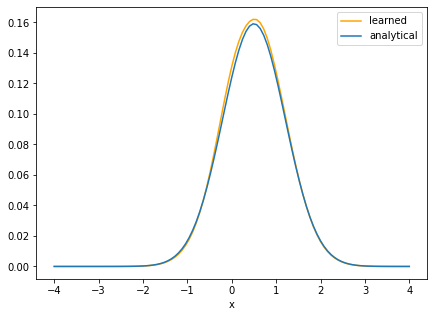

In [15]:
plot_pxz_fixed_z(0.5)

### Step 2: Compare learned and analytical likelihood.
Plot p(x|z) as a function of z for fixed x

In [18]:
def plot_pxz_fixed_x(point):
    zs = np.linspace(0,1,101).reshape((101,1)).astype(np.float32)
    points = np.full((101,2), point).astype(np.float32)
    #print(xs.shape, zs.shape)
    start = time.time()
    neg_probs = -new_model.conditional_prob(points, zs)
    end = time.time()
    #print(end-start)
    fig_zs_1 = plt.figure(figsize=(7,5))
    plt.plot(zs, -neg_probs, label="learned")
    
    x, y = point
    analytical = np.array([-np.exp(-(x-z)**2/2) * np.exp(-(y-z)**2/2)/(2*np.pi) for z in zs]).reshape((101,))
    plt.plot(zs, -analytical, label="analytical", c='orange')
    #print(neg_probs.shape)
    #print(analytical.shape)
    #plt.plot(zs, analytical/neg_probs, label="ratio", c='orange')
    plt.xlabel("z")
    plt.legend()

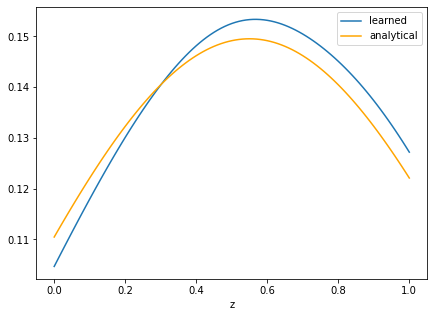

In [22]:
fixed_point = [0.3, 0.8]
plot_pxz_fixed_x(fixed_point)

## Playing with gradient-based methods for inference

Below I'm trying out the example from https://www.tensorflow.org/probability/examples/Optimizers_in_TensorFlow_Probability

In [15]:
%matplotlib inline

import contextlib
import functools
import os
import time

import numpy as np
import pandas as pd
import scipy as sp
from six.moves import urllib
from sklearn import preprocessing

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

In [16]:
CACHE_DIR = os.path.join(os.sep, 'tmp', 'datasets')


def make_val_and_grad_fn(value_fn):
    @functools.wraps(value_fn)
    def val_and_grad(x):
        return tfp.math.value_and_gradient(value_fn, x)
    return val_and_grad


@contextlib.contextmanager
def timed_execution():
    t0 = time.time()
    yield
    dt = time.time() - t0
    print('Evaluation took: %f seconds' % dt)


def np_value(tensor):
    """Get numpy value out of possibly nested tuple of tensors."""
    if isinstance(tensor, tuple):
        return type(tensor)(*(np_value(t) for t in tensor))
    else:
        return tensor.numpy()

def run(optimizer):
    """Run an optimizer and measure it's evaluation time."""
    optimizer()  # Warmup.
    with timed_execution():
        result = optimizer()
    return np_value(result)

In [55]:
# Fix numpy seed for reproducibility
np.random.seed(12345)

# The objective must be supplied as a function that takes a single
# (Tensor) argument and returns a tuple. The first component of the
# tuple is the value of the objective at the supplied point and the
# second value is the gradient at the supplied point. The value must
# be a scalar and the gradient must have the same shape as the
# supplied argument.

# The `make_val_and_grad_fn` decorator helps transforming a function
# returning the objective value into one that returns both the gradient
# and the value. It also works for both eager and graph mode.

dim = 10
minimum = np.ones([dim])
var = np.ones([dim])*2
scales = np.exp(np.random.randn(dim))
#scales = np.array([0.001]*dim)

@make_val_and_grad_fn
def quadratic(x):
    res = tf.reduce_sum(scales * (x - minimum) ** 2, axis=-1)
    #tf.print(res)
    return res


# The minimization routine also requires you to supply an initial
# starting point for the search. For this example we choose a random
# starting point.
start = np.random.randn(dim)

# Finally an optional argument called tolerance let's you choose the
# stopping point of the search. The tolerance specifies the maximum
# (supremum) norm of the gradient vector at which the algorithm terminates.
# If you don't have a specific need for higher or lower accuracy, leaving
# this parameter unspecified (and hence using the default value of 1e-8)
# should be good enough.
tolerance = 1e-10

@tf.function
def quadratic_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
      quadratic,
      initial_position=tf.constant(start),
      tolerance=tolerance)

results = run(quadratic_with_lbfgs)

# The optimization results contain multiple pieces of information. The most
# important fields are: 'converged' and 'position'.
# Converged is a boolean scalar tensor. As the name implies, it indicates
# whether the norm of the gradient at the final point was within tolerance.
# Position is the location of the minimum found. It is important to check
# that converged is True before using the value of the position.

print('L-BFGS Results')
print('Function: quadratic')
print('Converged:', results.converged)
print('Location of the minimum:', results.position)
print('Number of iterations:', results.num_iterations)

Evaluation took: 0.024226 seconds
L-BFGS Results
Function: quadratic
Converged: True
Location of the minimum: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of iterations: 10


Let's change things up slightly, and do the same thing to minimize a negative Gaussian.

In [52]:
dim = 10
minimum = np.ones([dim])
var = np.array([1] * dim)
start = np.random.randn(dim)
tolerance = 1e-10

print(tf.constant(start))

@make_val_and_grad_fn
def neg_gaussian(x):
    #print(-tf.math.exp(-(x - minimum)**2/var))
    res = tf.reduce_sum(-tf.math.exp(-(x - minimum)**2/var), axis=-1)
    #tf.print("Result:", res)
    return res

@tf.function
def neg_gaussian_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
      neg_gaussian,
      initial_position=tf.constant(start),
      tolerance=tolerance)

results = run(neg_gaussian_with_lbfgs)

print('L-BFGS Results')
print('Function: neg_gaussian')
print('Variance:', var)
print('Converged:', results.converged)
print('Location of the minimum:', results.position)
print('Number of iterations:', results.num_iterations)

tf.Tensor(
[-0.71354399 -0.83115354 -2.37023165 -1.86076079 -0.8607574   0.56014529
 -1.26593449  0.11982712 -1.06351245  0.33288272], shape=(10,), dtype=float64)
Evaluation took: 0.077952 seconds
L-BFGS Results
Function: neg_gaussian
Variance: [1 1 1 1 1 1 1 1 1 1]
Converged: True
Location of the minimum: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of iterations: 28


In [ ]:
@tf.function
def neg_gaussian_with_bfgs():
    return tfp.optimizer.bfgs_minimize(
      neg_gaussian,
      initial_position=tf.constant(start),
      tolerance=tolerance)

results = run(neg_gaussian_with_bfgs)

print('BFGS Results')
print('Function: neg_gaussian')
print('Variance:', var)
print('Converged:', results.converged)
print('Location of the minimum:', results.position)
print('Number of iterations:', results.num_iterations)

In [ ]:
x0 = np.zeros([dim])
neg_gaussian(x0)

Finally, let's use the L-BFGS optimizer to minimize the function we care about, $p(x|z)$.

In [75]:
import scipy.optimize

def scipy_opt(point, start):
    start_time = time.time()
    
    @tf.function
    def cond_prob_scalar(x, z):
        x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
        z_tensor = tf.cast(tf.reshape(z, (1, 1)), tf.float32)
        output = new_model.conditional_prob(x_tensor, z_tensor)
        #tf.print("Output", output)
        return output

    @make_val_and_grad_fn
    def neg_cond_prob(z):
        #tf.print("z:", z)
        point_correct_dim = np.full((1,2), point).astype(np.float32)
        output = tf.reduce_sum(-cond_prob_scalar(point_correct_dim, z), axis=-1)
        #tf.print(output)
        return output

    def fun(z):
        #print("eval f at:", point)
        val, deriv = neg_cond_prob(z)
        return val.numpy()

    def fun_deriv(z):
        #print("eval f' at:", point)
        val, deriv = neg_cond_prob(z)
        return deriv.numpy()
    
    start = np.array([start])

    result = scipy.optimize.minimize(
        fun=fun,
        x0=start,
        method="bfgs",
        jac=fun_deriv,
    )

    print(f"Evaluation took: {time.time()-start_time} seconds")
    return result

scipy_opt([0.5,0.5], 1.0)

Evaluation took: 10.860492944717407 seconds


      fun: -0.16899080574512482
 hess_inv: array([[3.61884072]])
      jac: array([3.3899803e-05], dtype=float32)
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 61
      nit: 3
     njev: 49
   status: 2
  success: False
        x: array([0.46081405])

This is what ended up working, using scipy optimizers.

In [87]:
import scipy.optimize

fixed_x = [0.3,0.3]
fixed_x_12 = np.full((1,2), fixed_x).astype(np.float32)

@tf.function
def cond_prob_scalar(x, z):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    z_tensor = tf.cast(tf.reshape(z, (1, 1)), tf.float32)
    output = new_model.conditional_prob(x_tensor, z_tensor)
    #tf.print("Output", output)
    return output

@make_val_and_grad_fn
def neg_cond_prob(z):
    #tf.print("z:", z)
    output = tf.reduce_sum(-cond_prob_scalar(fixed_x_12, z), axis=-1)
    #tf.print(output)
    return output

def fun(point):
    #print("eval f at:", point)
    val, deriv = neg_cond_prob(point)
    return val.numpy()

def fun_deriv(point):
    #print("eval f' at:", point)
    val, deriv = neg_cond_prob(point)
    return deriv.numpy()

start = np.array([0.3])

start_time = time.time()
result = scipy.optimize.minimize(
    fun=fun,
    x0=start,
    method="BFGS",
    jac=fun_deriv,
)

print(f"Evaluation took: {time.time()-start_time} seconds")
print(result)

Evaluation took: 16.313994646072388 seconds
      fun: -0.15091665089130402
 hess_inv: array([[12.53186413]])
      jac: array([-0.00012272], dtype=float32)
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 79
      nit: 4
     njev: 68
   status: 2
  success: False
        x: array([0.23702528])


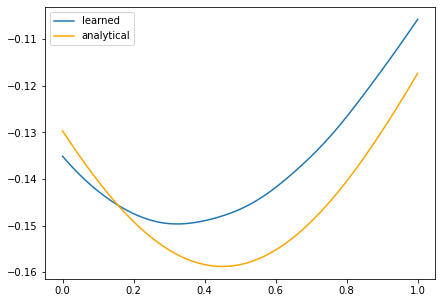

In [88]:
fixed_point = [0.4, 0.5]
plot_pxz_fixed_x(fixed_point)

In [85]:
scanner(tf.constant([0.3,0.3],dtype=tf.float32),100)

0.2

In [ ]:
# OLD: Use optimizer in TensowFlow. I could not get it to work :(
fixed_x = [0.3,0.3]
fixed_x_12 = np.full((1,2), fixed_x).astype(np.float32)
print(fixed_x_12)

@tf.function
def cond_prob_scalar(x, z):
    #print(f"x = {x.shape}{x.dtype} {type(x)}  z = {z.shape}{z.dtype} {type(z)}")
    #print(f"x = {x}, z = {z}")
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    z_tensor = tf.cast(tf.reshape(z, (1, 1)), tf.float32)
    output = new_model.conditional_prob(x_tensor, z_tensor)
    tf.print("Output", output)
    return output
    #return tf.constant([0.5])

@make_val_and_grad_fn
def neg_cond_prob(z):
    tf.print("z:", z)
    output = tf.reduce_sum(-cond_prob_scalar(fixed_x_12, z), axis=-1)
    tf.print(output)
    return output

@tf.function
def neg_cond_prob_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
      neg_cond_prob,
      initial_position=tf.constant(start, dtype=tf.float32),
      tolerance=tolerance)

## Prior-independence

One reason for using a normalizing flow for this simple inferential task is that flows can learn in a priors-independent fashion. Below, we change up the distribution from which the training dataset was drawn, from a uniform distribution to a Gaussian distribution. Then, we train a second flow to perform the same inferential task as above. We will see that it does equally well as the original flow, and produces the same calibration curve. We compare its performance to a simple linear regressor such as the one from scikit learn.

In [216]:
# Target dataset: 2D Gaussians centered at (c,c)
DATASET_SIZE = 1024 * 8 * 50
BATCH_SIZE = 256

def generate_2D_gaussian_gaussian(n):
    cond_vals = np.random.normal(0.5, 1, (n,1))
    samples = np.empty([n,2]).astype(np.float32)
    for i in range(n):
        samples[i] = np.random.normal(cond_vals[i], 1, (1,2))
    return np.concatenate([samples, cond_vals],-1) #Last dimensions are the conditional values

samples_train_gaussian = generate_2D_gaussian_gaussian(DATASET_SIZE)
#samples_val = generate_2D_gaussian(VAL_SIZE)

print(f"Training samples: {samples_train_gaussian}")

Training samples: [[ 0.1557508  -0.39925289 -0.75122065]
 [ 0.87838799  1.28830421  0.76694214]
 [-0.14462547 -2.43893671 -0.85991729]
 ...
 [ 0.17943162  1.64214408  0.45714972]
 [-0.07309303 -0.76550174 -0.03231828]
 [ 1.3263582   0.85773402  0.54705092]]


In [226]:
samples_train_gaussian.shape

(409600, 3)

In [ ]:
LR = 5e-4
NUM_EPOCHS = 40
STACKED_FFJORDS = 5 #Number of stacked transformations
NUM_LAYERS = 3 #Hiddden layers per bijector
NUM_OUTPUT = 2 #Output dimension
NUM_HIDDEN = 12*NUM_OUTPUT #Hidden layer node size
NUM_COND = 1 #Number of conditional dimensions


#Stack of bijectors 
stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT,NUM_COND)
    stacked_mlps.append(mlp_model)

#Create the model
model_gaus = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='hutchinson')
model_gaus.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))

callbacks=[
        EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)
    ]

trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams
print(f"Number of trainable params: {trainableParams}")
print(f"Number of nontrainable params: {nonTrainableParams}")
print(f"Number of total params: {totalParams}")

history_gaus = model_gaus.fit(
    samples_train_gaussian,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_split=0.1,
    #validation_data=samples_val,
    callbacks=callbacks,
)
    
num_epochs = callbacks[0].stopped_epoch

Number of trainable params: 3850
Number of nontrainable params: 2.0
Number of total params: 3852.0
Epoch 1/40
1440/1440 [==============================] - 276s 149ms/step - loss: 2.8539 - val_loss: 2.8576 - lr: 5.0000e-04
Epoch 2/40
1440/1440 [==============================] - 221s 153ms/step - loss: 2.8385 - val_loss: 2.8548 - lr: 5.0000e-04
Epoch 3/40
1440/1440 [==============================] - 224s 156ms/step - loss: 2.8468 - val_loss: 2.8507 - lr: 5.0000e-04
Epoch 4/40
1440/1440 [==============================] - 223s 155ms/step - loss: 2.8453 - val_loss: 2.8501 - lr: 5.0000e-04
Epoch 5/40
1440/1440 [==============================] - 225s 156ms/step - loss: 2.8425 - val_loss: 2.8331 - lr: 5.0000e-04
Epoch 6/40
1440/1440 [==============================] - 224s 156ms/step - loss: 2.8451 - val_loss: 2.8449 - lr: 5.0000e-04
Epoch 7/40
1440/1440 [==============================] - ETA: 0s - loss: 2.8435
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1440

In [292]:
NSAMPLES = DATASET_SIZE

#Sample the learned distribution
transformed_gaus = model_gaus.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model_gaus.flow.bijector, {'bijector.': {'conditional_input': samples_train_gaussian[:,2].reshape(NSAMPLES,1)}})
)

transformed_first_gaus = model_gaus.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model_gaus.flow.bijector, {'bijector.': {'conditional_input': np.ones((NSAMPLES,1),dtype=np.float32)}})
)

transformed_second_gaus = model_gaus.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model_gaus.flow.bijector, {'bijector.': {'conditional_input': np.zeros((NSAMPLES,1),dtype=np.float32)}})
)

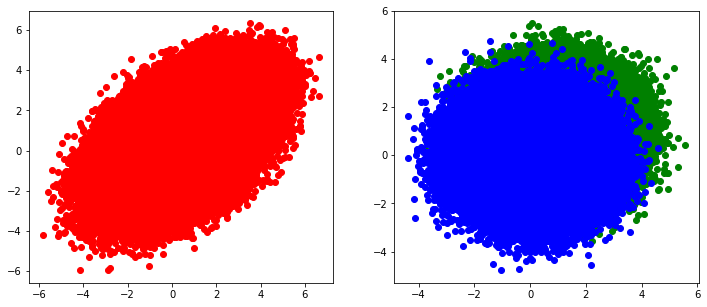

In [293]:
#Plotting    
fig = plt.figure(figsize=(12, 5))
plt.subplot(121)    
plt.scatter(transformed_gaus[:, 0], transformed_gaus[:, 1], color="r")
plt.subplot(122)
plt.scatter(transformed_first_gaus[:, 0], transformed_first_gaus[:, 1], color="g")
plt.scatter(transformed_second_gaus[:, 0], transformed_second_gaus[:, 1], color="b")

In [296]:
# Saving the model for future inference
save_model(model_gaus)

# Let's create a new model with the same architecture, but with the exact trace estimator
new_model_gaus = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='exact',name='loaded_model')
load_model(new_model_gaus)

In [294]:
def scanner_gaus(point, N):
    points = np.array([point] * (N+1))
    zs = np.array([i/N for i in range(N+1)]).reshape((N+1,1))
    log_probs = new_model_gaus.conditional_log_prob(points, zs)

    max_prob = np.amax(log_probs)
    max_index = np.argmax(log_probs)

    c_max = max_index / N
    return c_max

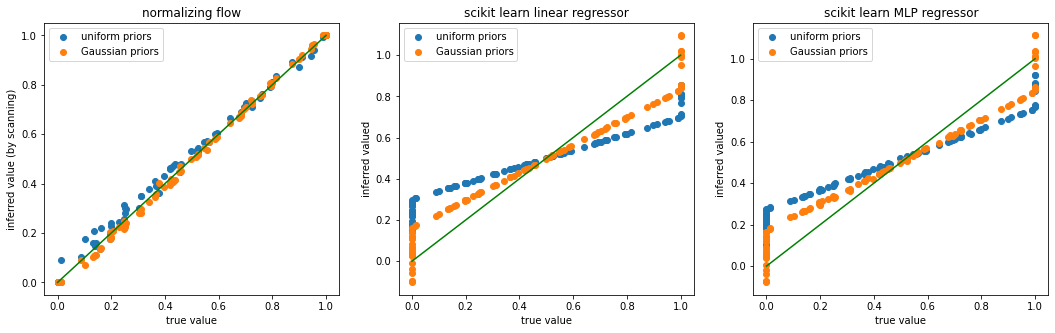

In [304]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

N = 500
n_points = 100

points = np.random.uniform(-0.5, 1.5, (n_points,2)).astype(np.float32)
#print(points)

c_maxs = []
c_max_gauss = []
c_max_maths = []

# inferencec with the flow
for point in points:
    c_max = scanner(point, N)
    c_max_gaus = scanner_gaus(point, N)
    c_max_math = mle_math(point)
    c_maxs.append(c_max)
    c_max_gauss.append(c_max_gaus)
    c_max_maths.append(c_max_math)

# linear regressor, uniform priors
coords = samples_train[:,0:2]
conds = samples_train[:,2]
reg = LinearRegression().fit(coords, conds)
c_max_linregs = reg.predict(points)

# linear regressor, Gaussian priors
coords_gaus = samples_train_gaussian[:,0:2]
conds_gaus = samples_train_gaussian[:,2]
reg_gaus = LinearRegression().fit(coords_gaus, conds_gaus)
c_max_linreg_gauss = reg_gaus.predict(points)

# MLP regressor
mlpreg = MLPRegressor(random_state=1, max_iter=500).fit(coords, conds)
c_max_mlpregs = mlpreg.predict(points)
mlpreg_gaus = MLPRegressor(random_state=1, max_iter=500).fit(coords_gaus, conds_gaus)
c_max_mlpreg_gauss = mlpreg_gaus.predict(points)

fig = plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.scatter(c_max_maths, c_maxs, label="uniform priors")
plt.scatter(c_max_maths, c_max_gauss, label="Gaussian priors")
plt.xlabel("true value")
plt.ylabel("inferred value (by scanning)")
plt.title("normalizing flow")
plt.plot([0,0.5,1], [0,0.5,1], c='green')
plt.legend()
plt.subplot(132)
plt.scatter(c_max_maths, c_max_linregs, label="uniform priors")
plt.scatter(c_max_maths, c_max_linreg_gauss, label="Gaussian priors")
plt.xlabel("true value")
plt.ylabel("inferred valued")
plt.title("scikit learn linear regressor")
plt.plot([0,0.5,1], [0,0.5,1], c='green')
plt.legend()
plt.subplot(133)
plt.scatter(c_max_maths, c_max_mlpregs, label="uniform priors")
plt.scatter(c_max_maths, c_max_mlpreg_gauss, label="Gaussian priors")
plt.xlabel("true value")
plt.ylabel("inferred valued")
plt.title("scikit learn MLP regressor")
plt.plot([0,0.5,1], [0,0.5,1], c='green')
plt.legend()

In [306]:
test = generate_2D_gaussian(n_points)

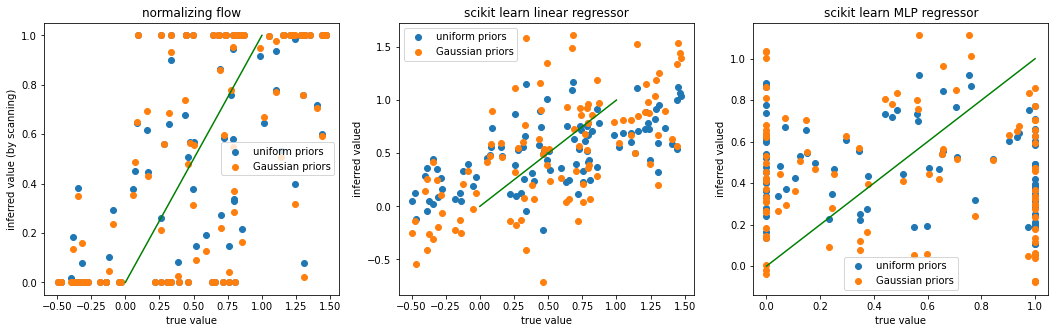

In [318]:
points = test[:,0:2].reshape((n_points,2)).astype(np.float32)
true_vals = test[:,2]

c_maxs = []
c_max_gauss = []
c_max_maths = []

# inferencec with the flow
for point in points:
    c_max = scanner(point, N)
    c_max_gaus = scanner_gaus(point, N)
    c_max_math = mle_math(point)
    c_maxs.append(c_max)
    c_max_gauss.append(c_max_gaus)
    c_max_maths.append(c_max_math)

# linear regressor, uniform priors
coords = samples_train[:,0:2]
conds = samples_train[:,2]
reg = LinearRegression().fit(coords, conds)
c_max_linregs = reg.predict(points)

# linear regressor, Gaussian priors
coords_gaus = samples_train_gaussian[:,0:2]
conds_gaus = samples_train_gaussian[:,2]
reg_gaus = LinearRegression().fit(coords_gaus, conds_gaus)
c_max_linreg_gauss = reg_gaus.predict(points)

# MLP regressor
#mlpreg = MLPRegressor(random_state=1, max_iter=500).fit(coords, conds)
#c_max_mlpregs = mlpreg.predict(points)
#mlpreg_gaus = MLPRegressor(random_state=1, max_iter=500).fit(coords_gaus, conds_gaus)
#c_max_mlpreg_gauss = mlpreg_gaus.predict(points)

fig = plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.scatter(true_vals, c_maxs, label="uniform priors")
plt.scatter(true_vals, c_max_gauss, label="Gaussian priors")
plt.xlabel("true value")
plt.ylabel("inferred value (by scanning)")
plt.title("normalizing flow")
plt.plot([0,0.5,1], [0,0.5,1], c='green')
plt.legend()
plt.subplot(132)
plt.scatter(true_vals, c_max_linregs, label="uniform priors")
plt.scatter(true_vals, c_max_linreg_gauss, label="Gaussian priors")
plt.xlabel("true value")
plt.ylabel("inferred valued")
plt.title("scikit learn linear regressor")
plt.plot([0,0.5,1], [0,0.5,1], c='green')
plt.legend()
plt.subplot(133)
plt.scatter(c_max_maths, c_max_mlpregs, label="uniform priors")
plt.scatter(c_max_maths, c_max_mlpreg_gauss, label="Gaussian priors")
plt.xlabel("true value")
plt.ylabel("inferred valued")
plt.title("scikit learn MLP regressor")
plt.plot([0,0.5,1], [0,0.5,1], c='green')
plt.legend()